In [1]:
import os
import cv2
import glob
import json
import time
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
#from progressbar import * #进度条
from tqdm import tqdm #进度条
from torchnet import meter
from natsort import natsorted
import matplotlib.pyplot as plt
import torch.nn.functional as F #torch是关于运算的包
from collections import defaultdict
from torch.autograd import Variable
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
from torchvision import datasets,transforms, models #torchvision则是打包了一些数据集
#from sklearn.cross_validation import train_test_split
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transforms=None):
        self.imageFolderDataset = imageFolderDataset
        self.transforms = transforms
        #数据增强
        if transforms is None:
            normalize = T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            #训练集用数据增强
            self.transforms = T.Compose([
                #T.RandomCrop(224, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32`，
                T.Resize(256),
                T.RandomResizedCrop(224),
                T.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
                #T.RandomVerticalFlip(),
                T.Grayscale(3),
                T.ToTensor(),
                #normalize 
            ])
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")#转化为灰度
        #img1 = img1.convert("L")
        img0 = self.transforms(img0)
        img1 = self.transforms(img1)
        '''
        if self.should_invert:#是否进行像素反转操作，即0变1， 1变0
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.imageOps.invert(img1)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        '''
        #返回的标签，如果不相等 返回1， 相等 返回2
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
folder_dataset = datasets.ImageFolder('/home/lhw/kaggle/cifar_10/data/new_train')#在cifar10数据集上做测试

In [4]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset)
print(len(siamese_dataset))

50000


In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

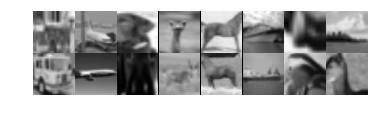

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [6]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #vgg-16
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),#[64, 112, 112]
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),#[128, 56, 56]
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),#[256, 28, 28]
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),#[512, 14, 14]
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),#[512, 7, 7]
            
        )
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024)
        )
    def forward_once(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [8]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        #降低相似时的损失，
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [9]:
net = SiameseNetwork()
x1 = torch.randn(2, 3, 224, 224)
#x2 = torch.randn(2, 3, 224, 224)
x2 = x1
y1, y2 = net(x1, x2)
print(y1, y2)
criterion = ContrastiveLoss()
print(criterion(y1, y2, 0))

tensor([[ 2.9373e-03, -8.0169e-03, -1.2507e-02,  ...,  7.5759e-03,
          1.0727e-03,  6.4050e-03],
        [-6.5895e-03, -3.9596e-03, -1.1433e-02,  ...,  1.0293e-02,
         -1.3417e-03, -9.9541e-05]], grad_fn=<ThAddmmBackward>) tensor([[ 5.9901e-03, -6.0746e-03, -1.3181e-02,  ...,  6.0904e-03,
          3.2377e-03,  8.1570e-04],
        [ 5.6841e-03, -5.6051e-03, -5.8024e-03,  ..., -3.0577e-04,
          6.3891e-03, -5.6065e-03]], grad_fn=<ThAddmmBackward>)
tensor(0.0317, grad_fn=<MeanBackward1>)


In [10]:
#训练参数
batch_size = 18
lr = 0.0001
lr_decay = 0.995
weight_decay = 1e-4
#epochs = 300
train_number_epochs = 800
model_path = 'model/siamesenetwork_cifar10.ckpt'
min_loss = 10000
pre_epoch = 0
max_interval_epoch = 10
pre_train_loss = 10000

In [ ]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=batch_size)
net = SiameseNetwork()
#if os.path.exists(model_path):
#    net = torch.load(model_path)
net = net.cuda()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = lr)
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0, train_number_epochs):
    train_loss = 0
    train_count = 0
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        train_count += img1.size(0)
        train_loss += loss_contrastive.data[0]
   
    train_loss /= train_count
    print("Epoch number {} Current loss {}".format(epoch,train_loss))
    counter.append(epoch)
    loss_history.append(train_loss)
    #保存模型
    if min_loss > train_loss:
        min_loss = train_loss
        pre_epoch = epoch
        torch.save(net, model_path)#保存整个神经网络的的结构信息和模型参数信息，save的对象是网络net
    if epoch - pre_epoch > max_interval_epoch:
        print('early stop')
        break
    #如果损失不载下降，则降低学习率
    if train_loss > pre_train_loss:
        lr = lr*lr_decay
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    pre_train_loss = train_loss
show_plot(counter,loss_history)

/home/lhw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch number 0 Current loss 0.05578310415148735


/home/lhw/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
net = torch.load(model_path)
net = net.cuda()
for i in range(10):
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    print(label2.numpy())
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0]))